# Prix des logements - Problème de régression avancée

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Les données proviennent de ce concours :
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
Elles sont composées de 81 colonnes et 2911 lignes

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import scipy.stats as ss
import nltk
import os
import re
import warnings
import lightgbm as lgb
from time import time
import pickle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score
from IPython.display import FileLinks
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.linear_model import ElasticNetCV, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from decimal import Decimal as Dec
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## [MISSION 1: RECUPERATION ET TRAITEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

### [M1-1 : Récuperation des données](#sommaire)<a class="anchor" id="6"></a>

In [3]:
# Les données d'entrainement : toutes les variables + le prix
df_train = pd.read_csv('data/train.csv',
                       sep=',', engine='python')

# Les données de test avec toutes les variables sauf le prix
df_test = pd.read_csv('data/test.csv',
                      sep=',', engine='python')

# Les prix des données dans fichier test et l'id
df_sample_submission = pd.read_csv('data/sample_submission.csv',
                                   sep=',', engine='python')

In [4]:
print('Entrainement : {} lignes et {} colonnes.'.format(df_train.shape[0],
                                                        df_train.shape[1]))
print('Test : {} lignes et {} colonnes.'.format(df_test.shape[0], df_test.shape[1]))

Entrainement : 1460 lignes et 81 colonnes.
Test : 1459 lignes et 80 colonnes.


#### Fusion des deux fichiers pour n'avoir qu'un

In [5]:
# Conservation de l'index pour identifier le df_train
train_index = df_train.index

# Jointure de la base d'apprentissage et la base de test
fusion_data_test = pd.merge(df_test, df_sample_submission,
                            how="right", left_on="Id", right_on="Id")
df = df_train.append(fusion_data_test).reset_index(drop=True)
# df = df_train.append(df_test).reset_index(drop=True)

# Suppression de la variable Id de la base "df"
df.drop("Id", axis=1, inplace=True)
print('dataframe final : {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

dataframe final : 2919 lignes et 80 colonnes.


### [M1-2 : Analyse et exploration des données](#sommaire)<a class="anchor" id="7"></a>

#### Répartition des prix :

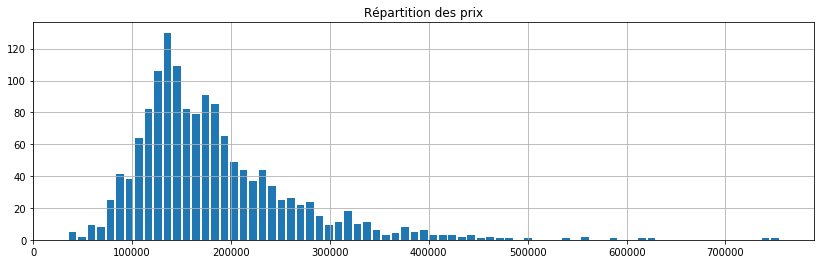

In [6]:
df_train.SalePrice.hist(bins=75, rwidth=.8, figsize=(14, 4))
plt.title('Répartition des prix')
plt.show()

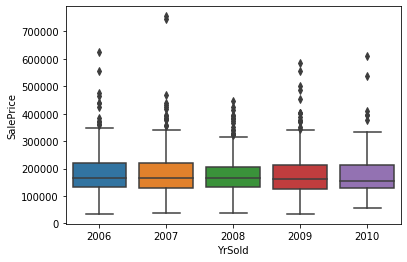

In [7]:
# Variation des prix de vente des logement selon l'année de vente
ax = sns.boxplot(x="YrSold", y="SalePrice", data=df_train)
plt.show()

#### Période de construction et de rénovation :

Text(0.5, 1.0, 'Période de construction et de rénovation ')

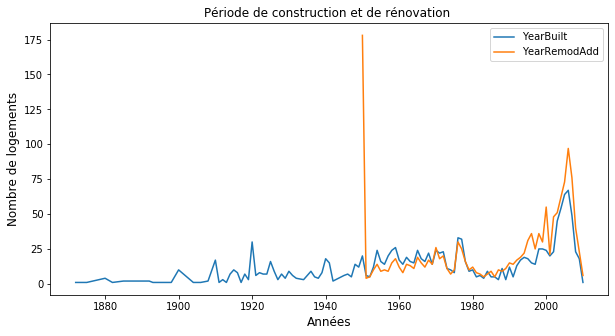

In [8]:
plt.figure(figsize=(10, 5))
# Date de construction
df_train.YearBuilt.value_counts().sort_index().plot()
plt.legend(loc='best')
# Date de Renovation
df_train.YearRemodAdd.value_counts().sort_index().plot()
plt.legend(loc='best')
plt.xlabel('Années', fontsize=12)
plt.ylabel('Nombre de logements', fontsize=12)
plt.title('Période de construction et de rénovation ')

#### Période de vente :

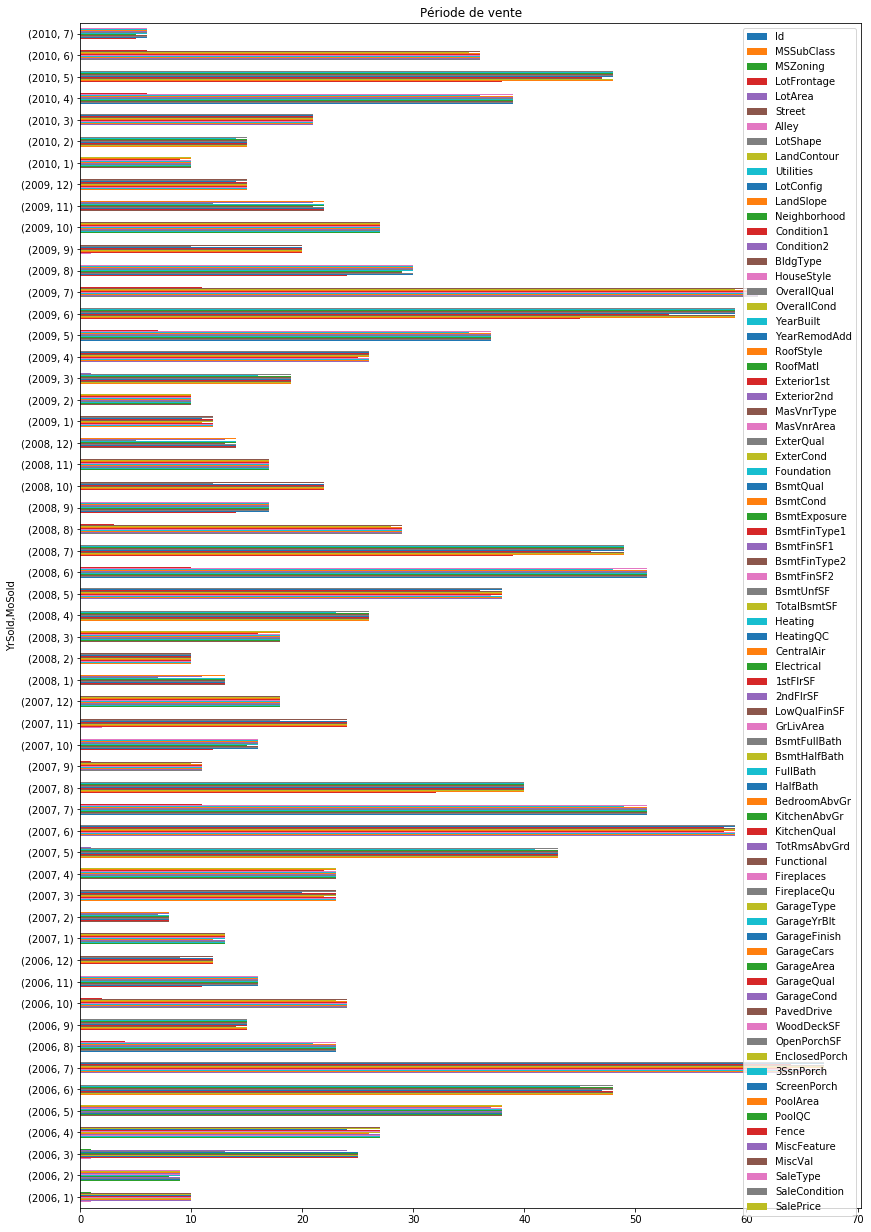

In [9]:
df_train.groupby(['YrSold', 'MoSold']).count().plot(kind='barh',
                                                    figsize=(14, 21.8))
plt.title('Période de vente')
plt.show()

#### Preprocessing : 

##### Déterminer les taux de remplissage des variables.
- Retirer les variables trop peu remplies

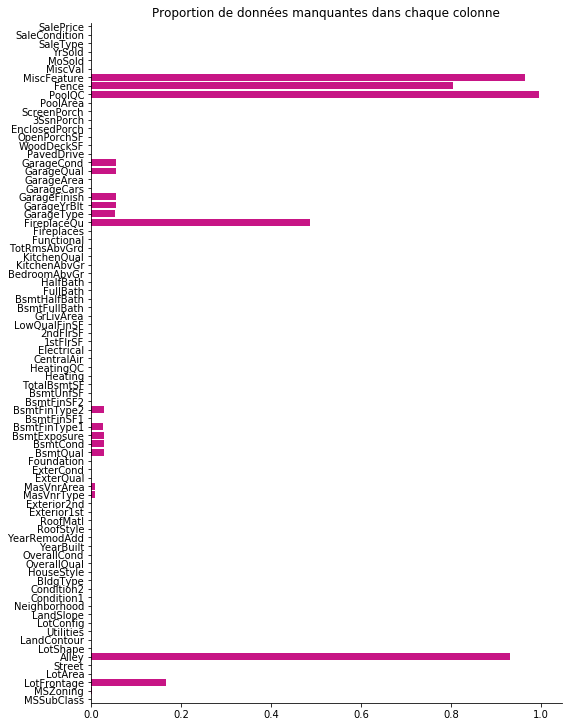

In [10]:
# Supprimer les colonnes trop peu remplies
#   La proportion de valeurs manquantes par colonne
# permettra de connaitre les colonnes à supprimer
null_counts = df.isnull().mean(axis=0)

#   barplot des valeurs manquantes par colonne
fig = plt.figure(figsize=(8, 10))
plt.barh(np.arange(len(null_counts)), null_counts, color="mediumvioletred")
plt.yticks(np.arange(len(null_counts)), null_counts.index,
           rotation=0, fontsize=10)
sns.despine()
plt.margins(y=0)
plt.tight_layout()
plt.title('Proportion de données manquantes dans chaque colonne')
plt.show()

In [11]:
# Les variables ayant plus de 40% de valeurs manquantes
colsdel = list(df.columns[df.isnull().sum() / len(df) > 0.40])
df.drop(colsdel, axis=1, inplace=True)

In [12]:
# Les colonnes supprimées car n'ont pas suffisament des données sont :
colsdel

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
# Selection des variables categorielles
categorical_cols = [cname for cname in df.columns
                    if df[cname].dtype == 'object']
print(len(categorical_cols), 'variables catégorielles = ', categorical_cols)

38 variables catégorielles =  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [14]:
# Selection des variables numériques
numeric_cols = [cname for cname in df.columns
                if df[cname].dtype in ['int64', 'float64']]
print(len(numeric_cols), 'variables numériques = ', numeric_cols)

37 variables numériques =  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [15]:
# Imputation des variables quantititatives manquantes par 0
varQuant = ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1",
            "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath",
            "BsmtHalfBath", "MasVnrArea"]
df[varQuant] = df[varQuant].apply(lambda x: x.fillna(0), axis=1)
del varQuant
# Imputation des variables qualitatives manquantes par Absent
varQual = ["GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2", "MasVnrType", "MSSubClass"]
df[varQual] = df[varQual].apply(lambda x: x.fillna('Absent'), axis=1)
del varQual

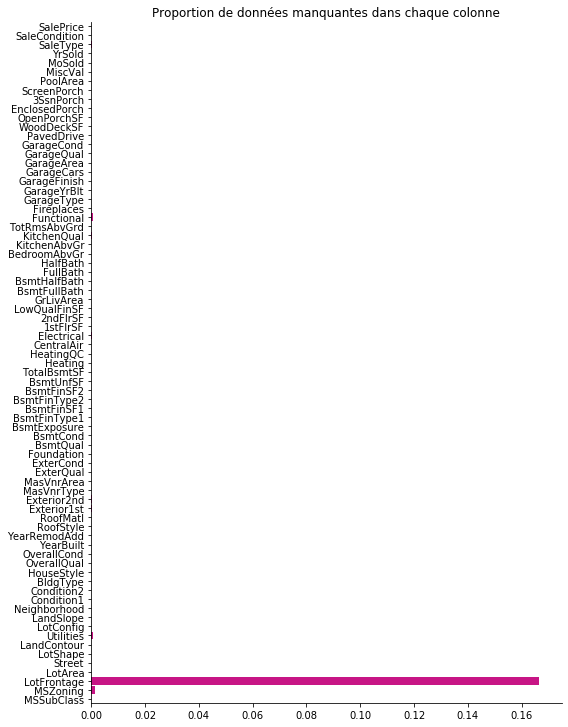

In [16]:
null_counts = df.isnull().mean(axis=0)

#   barplot des valeurs manquantes par colonne
fig = plt.figure(figsize=(8, 10))
plt.barh(np.arange(len(null_counts)), null_counts, color="mediumvioletred")
plt.yticks(np.arange(len(null_counts)), null_counts.index,
           rotation=0, fontsize=10)
sns.despine()
plt.margins(y=0)
plt.tight_layout()
plt.title('Proportion de données manquantes dans chaque colonne')
plt.show()

In [17]:
# Variables avec valeurs manquantes inexpliquées
def missing(df):
    df_null = pd.DataFrame([df.isnull().sum(),
                            round(100*df.isnull().sum()/len(df), 2),
                            df.dtypes]).transpose().reset_index()
    df_null.columns = ["variable", "valeur_NA", "Pourcentage_NA", "type"]
    df_null = df_null[df_null.valeur_NA
                      != 0].sort_values("valeur_NA",
                                        ascending=False).reset_index(drop=True)
    return df_null

missing(df)

,variable,valeur_NA,Pourcentage_NA,type
0,LotFrontage,486,16.65,float64
1,MSZoning,4,0.14,object
2,Utilities,2,0.07,object
3,Functional,2,0.07,object
4,Exterior1st,1,0.03,object
5,Exterior2nd,1,0.03,object
6,Electrical,1,0.03,object
7,KitchenQual,1,0.03,object
8,SaleType,1,0.03,object


- Imputation des variables qualitatives inexpliquées :

In [18]:
# Imputation par la mediane pour la variable numerique LotFrontage
df["LotFrontage"] = df.groupby("Neighborhood")[
    "LotFrontage"].transform(lambda x: x.fillna(x.median()))

- Imputation des variables categorielles :

In [19]:
# Nombre de cardinalité pour les variables manquantes :
print('cardinalité de Utilities : ', df['Utilities'].nunique())
print(pd.crosstab(df.Utilities, columns="Utilities"))
print('cardinalité de MSZoning : ', df['MSZoning'].nunique())
print(pd.crosstab(df.MSZoning, columns="MSZoning"))
print('cardinalité de Functional : ', df['Functional'].nunique())
print(pd.crosstab(df.Functional, columns="Functional"))
print('cardinalité de Exterior1st : ', df['Exterior1st'].nunique())
print(pd.crosstab(df.Exterior1st, columns="Exterior1st"))
print('cardinalité de Exterior2nd : ', df['Exterior2nd'].nunique())
print(pd.crosstab(df.Exterior2nd, columns="Exterior2nd"))
print('cardinalité de Electrical : ', df['Electrical'].nunique())
print(pd.crosstab(df.Electrical, columns="Electrical"))
print('cardinalité de KitchenQual : ', df['KitchenQual'].nunique())
print(pd.crosstab(df.KitchenQual, columns="KitchenQual"))
print('cardinalité de SaleType : ', df['SaleType'].nunique())
print(pd.crosstab(df.SaleType, columns="SaleType"))

cardinalité de Utilities :  2
col_0      Utilities
Utilities           
AllPub          2916
NoSeWa             1
cardinalité de MSZoning :  5
col_0     MSZoning
MSZoning          
C (all)         25
FV             139
RH              26
RL            2265
RM             460
cardinalité de Functional :  7
col_0       Functional
Functional            
Maj1                19
Maj2                 9
Min1                65
Min2                70
Mod                 35
Sev                  2
Typ               2717
cardinalité de Exterior1st :  15
col_0        Exterior1st
Exterior1st             
AsbShng               44
AsphShn                2
BrkComm                6
BrkFace               87
CBlock                 2
CemntBd              126
HdBoard              442
ImStucc                1
MetalSd              450
Plywood              221
Stone                  2
Stucco                43
VinylSd             1025
Wd Sdng              411
WdShing               56
cardinalité de Exterior2nd :

In [20]:
# Suppression de la variable "Utilities"
df.drop("Utilities", axis=1, inplace=True)

In [21]:
# Autres variables
df["Functional"] = df["Functional"].fillna(df["Functional"].mode()[0])
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])
df["KitchenQual"] = df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])
df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])
df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])

In [22]:
print("Il reste {} valeurs manquantes".format(df.isnull().sum().sum()))

Il reste 0 valeurs manquantes


#### Suppression des outliers :

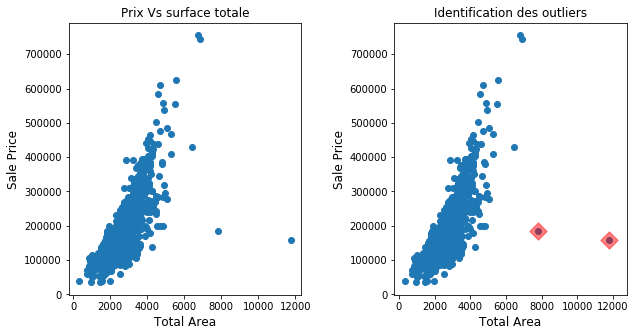

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x=df['GrLivArea'][train_index]+df["TotalBsmtSF"][train_index],
            y=df['SalePrice'][train_index])

plt.ylabel('Sale Price', fontsize=12)
plt.xlabel('Total Area', fontsize=12)
plt.gca().set_title('Prix Vs surface totale')

plt.subplot(1, 2, 2)
plt.scatter(x=df['GrLivArea'][train_index]+df["TotalBsmtSF"][train_index],
           y=df['SalePrice'][train_index])
# Outliers : les surface supérieurs à 6 000 et prix inferieur à 300 000
df1 = df.loc[train_index, ['GrLivArea', "TotalBsmtSF", 'SalePrice']]
t = list(df1.loc[(df1['GrLivArea'] + df1["TotalBsmtSF"] > 6000)
                 & (df1['SalePrice'] < 300000)].index)

plt.scatter(df1['GrLivArea'][t[0]]+df1["TotalBsmtSF"][t[0]],
            df1['SalePrice'][t[0]], color='r', marker='D', s=150, alpha=0.5)
plt.scatter(df1['GrLivArea'][t[1]]+df1["TotalBsmtSF"][t[1]],
            df1['SalePrice'][t[1]], color='r', marker='D', s=150, alpha=0.5)

plt.ylabel('Sale Price', fontsize=12)
plt.xlabel('Total Area', fontsize=12)
plt.gca().set_title('Identification des outliers')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [24]:
# Suppression des outliers
df.drop(t, axis=0, inplace=True)
train_index = [i for i in train_index if i not in t]

In [25]:
# Creation de nouvelles variables
# Age du logement (Année de vente - Année de construction)
df['AgeHouse'] = df['YrSold']-df['YearBuilt']

# Indicatrice si le logement à été rénové ou pas:
# 1 si YearBuild <> YearRemodAdd et O sinon
df['RemodHouse'] = 1*(df.YearBuilt != df.YearRemodAdd)

# Surface totale habitable du logement ( GrLivArea + TotalBsmtSF )
df["TotalArea"] = df["GrLivArea"]+df["TotalBsmtSF"]

# Ratio entre la surface habitable et la surface de la propriété
df["TotalArea"] = df["TotalArea"]/df["LotArea"]

# Ratio entre  Nbre Salles de bains / Nbre de chambres
df["BathRoomBedRoom"] = (df["FullBath"]+df["HalfBath"])/(1+df["BedroomAbvGr"])

df.drop("YearBuilt", axis=1, inplace=True)
df.drop("YearRemodAdd", axis=1, inplace=True)
df.drop("GarageYrBlt", axis=1, inplace=True)

## [MISSION 2: MODELISATION](#sommaire)<a class="anchor" id="9"></a>

#### Approche de modélisation :

In [26]:
# Mean Absolute Persentage Error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Root Mean Squared Error
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

#### Preparation des varaibles catégorielles

In [27]:
# variable cible = y_train
df_copy = df.copy()
y_train = df_copy.SalePrice[train_index]
df_copy.drop("SalePrice", axis=1, inplace=True)

# Labelisation des variables catégorielles ordonnées
# variables ayant pour echelle d'appréciation Ex,Gd,Ta,Fa,Po,Absent
var = ["BsmtQual", "BsmtCond", "GarageQual",
       "GarageCond", "ExterQual", "ExterCond",
       "HeatingQC", "KitchenQual"]

df_copy[var] = df_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Po", "Fa", "Ta", "Gd", "Ex"],
    ordered=True)).cat.codes, axis=1)

In [28]:
# Autres variables
var = ["BsmtFinType1", "BsmtFinType2"]
df_copy[var] = df_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ordered=True)).cat.codes, axis=1)

df_copy['GarageFinish'] = df_copy['GarageFinish'].astype(CategoricalDtype(
    categories=["Absent", "Unf", "RFn", "Fin"], ordered=True)).cat.codes

df_copy['BsmtExposure'] = df_copy['BsmtExposure'].astype(CategoricalDtype(
    categories=["Absent", "No", "Mn", "Av", "Gd"], ordered=True)).cat.codes

df_copy['LandSlope'] = df_copy['LandSlope'].astype(CategoricalDtype(
    categories=["Gtl", "Mod", "Sev"], ordered=True)).cat.codes

df_copy = df_copy.replace({'C (all)': 'Absent'})

df_copy.drop('Condition2', axis=1, inplace=True)

#### Encodage des variables catégorielles avec One-hot encoding

In [29]:
# Variables de type numérique et categoriel ordonnés recodés
var = ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
       'BedroomAbvGr', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'BsmtFinSF1',
       'GarageArea', 'GarageCars', 'GrLivArea',
       'HalfBath', 'KitchenAbvGr', 'BsmtFinSF2',
       'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MasVnrArea', 'MiscVal', 'OpenPorchSF',
       'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'WoodDeckSF', 'AgeHouse',
       'RemodHouse', 'BsmtQual',
       'BsmtCond', 'GarageQual', 'GarageCond',
       'ExterQual', 'ExterCond', 'HeatingQC',
       'KitchenQual', 'BsmtFinType1',
       'BsmtFinType2', 'GarageFinish', 'OverallCond',
       'MSSubClass', 'OverallQual', 'TotalArea',
       'BathRoomBedRoom', 'whisker']

# Transformation des variables non numériques en objet
nonVar = list(set(df_copy.columns).difference(set(var)))
df_copy[nonVar] = df_copy[nonVar].apply(lambda x: x.astype(str))

df_catboost = df_copy.copy()
# Nous allons tranformer toutes les autres variables en dummies
df_copy = pd.get_dummies(df_copy, columns=nonVar, sparse=True)
del var, nonVar

In [30]:
print(len(df_catboost.columns),
      ' colonnes et après One-hot encoding devient',
      len(df_copy.columns), 'colonnes')

73  colonnes et après One-hot encoding devient 238 colonnes


#### Repartition des données d'apprentissage et test :

In [31]:
# Données necesssaires à la modélisation directe

# POur les modeles nécéssitants de transfo des variables categorielles :
# Echantillon d'apprentissage, échantillon de validatin (train, valid sets)
df_train = df_copy.loc[train_index, ]

df_train, df_valid, y_train, y_valid = train_test_split(df_train,
                                                        y_train,
                                                        test_size=0.30)

# Echantillon test
df_test = df_copy.loc[[i for i in df_copy.index.tolist()
                       if i not in train_index], ]


In [32]:
# Fonctions utiles :
seed = 2021
np.random.seed(seed)
n_folds = 5


# methode pour calcul score de cross-validation(valid Root Mean Squared Error)
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    rmse = np.sqrt(- cross_val_score(model, df_train.values,
                                     y_train, scoring="neg_mean_squared_error",
                                     cv=kf))
    return(rmse)


# methode pour calcul score de cross-validation(Mean Absolute Percentage Error)
def mape_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    MAPE = np.abs(cross_val_score(model,
                                  df_train.values,
                                  y_train,
                                  scoring=make_scorer(
                                      mape,
                                      greater_is_better=False),
                                  cv=kf))
    return(MAPE)


# methode pour calculer le score de cross-validation (R2)
def r2_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    r2 = cross_val_score(model,
                         df_train.values, y_train,
                         scoring="r2", cv=kf)
    return(r2)

### [M2-1 : Le meilleur modèle ](#sommaire)<a class="anchor" id="13"></a>

In [33]:
# Define our base and meta models for stacking
base_models = (KernelRidge(),
               make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1)),
               make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9)),             
               make_pipeline(StandardScaler(),GradientBoostingRegressor(learning_rate=0.005, 
                                                                        loss='huber',
                                                                        max_depth=4, 
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=10,
                                                                        n_estimators=3000,
                                                                        random_state=1)))
meta_model = LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, 
                           feature_fraction=0.2319, feature_fraction_seed=9,
                           learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
                           min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
                           bagging_seed=9,objective='regression')

In [34]:
# Building the stacking model
kfold = KFold(n_splits=10)
stack = StackingCVRegressor(regressors=base_models,
                            meta_regressor=meta_model, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,cv=kfold,
                            random_state=1)
# fitting the model to our data
stack.fit(df_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189320626946.8802, tolerance: 620679839.3829758
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193866727821.71808, tolerance: 606299505.176759
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190401918632.4078, tolerance: 6174031

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 217644002730.81903, tolerance: 674618264.8748481
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 226602521642.67746, tolerance: 674618264.8748481
  positive)


StackingCVRegressor(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    meta_regressor=LGBMRegressor(bagging_fraction=0.8,
                                                 bagging_freq=5, bagging_seed=9,
                                                 feature_fraction=0.2319,
                                                 feature_fraction_seed=9,
                                                 learning_rate=0.05, max_bin=55,
                                                 min_data_in_leaf=6,
                                                 min_sum_hessian_in_leaf=11,
                                                 n_estimators=720, num_leaves=5,
                                                 objective='regression'),
                    random_state=1,
                    reg...
                                                 ElasticNet(alpha=0.0005,
                                                            l1_ratio=0.9))]),
                          

In [35]:
from sklearn.metrics import mean_squared_error
# see the results of the model for training

stack_score = round(stack.score(df_train, y_train)*100, 3)
predictions = stack.predict(df_train)
stack_rmse = round(np.sqrt(mean_squared_error(y_train, predictions).mean())*100, 3)
print(' _'*15)
print('\nStacking Results for trining test : \n')
print(f'Score : {stack_score}%')
print(f'RMSE  : {stack_rmse}%')
print(' _'*15)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.Data

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Stacking Results for trining test : 

Score : 97.908%
RMSE  : 1176416.048%
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [36]:
rmse_stack = rmse_cv(stack)
mape_stack = mape_cv(stack)
r2_stack = r2_cv(stack)

print('Stack RMSE: {:.3f} ({:.3f})'.format(
    rmse_stack.mean(), rmse_stack.std()))
print('Stack MAPE: {:.2f} ({:.2f})'.format(
    mape_stack.mean(), mape_stack.std()))
print('Stack R2: {:.2f} ({:.2f})'.format(
    r2_stack.mean(), r2_stack.std()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147080709672.28378, tolerance: 518787796.24324584
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141316323726.2682, tolerance: 490512874.33080393
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 142942337289.97464, tolerance: 480293424.48004985
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dual

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166208478073.8261, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173542372313.71277, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139415599489.98862, tolerance: 495282867.1353461
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162550936136.4268, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168791572764.42477, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120960393028.84901, tolerance: 499190506.7352133
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151982734688.80417, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158171180043.71097, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145464850426.34894, tolerance: 469239187.6040507
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167989119074.6669, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175379232044.62524, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127830934258.03395, tolerance: 494034110.3679188
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157239873553.85803, tolerance: 541096843.0039352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164290697641.82324, tolerance: 541096843.0039352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147080709672.28378, tolerance: 518787796.24324584
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166208478073.8261, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173542372313.71277, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139415599489.98862, tolerance: 495282867.1353461
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162550936136.4268, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168791572764.42477, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120960393028.84901, tolerance: 499190506.7352133
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151982734688.80417, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158171180043.71097, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145464850426.34894, tolerance: 469239187.6040507
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167989119074.6669, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175379232044.62524, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127830934258.03395, tolerance: 494034110.3679188
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157239873553.85803, tolerance: 541096843.0039352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164290697641.82324, tolerance: 541096843.0039352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 147080709672.28378, tolerance: 518787796.24324584
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166208478073.8261, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 173542372313.71277, tolerance: 552273694.0204936
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 139415599489.98862, tolerance: 495282867.1353461
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162550936136.4268, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168791572764.42477, tolerance: 542274449.9212937
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120960393028.84901, tolerance: 499190506.7352133
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 151982734688.80417, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158171180043.71097, tolerance: 546163804.288951
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145464850426.34894, tolerance: 469239187.6040507
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 167989119074.6669, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 175379232044.62524, tolerance: 516257088.6227725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127830934258.03395, tolerance: 494034110.3679188
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 157239873553.85803, tolerance: 541096843.0039352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164290697641.82324, tolerance: 541096843.0039352
  positive)


Stack RMSE: 23780.537 (1981.239)
Stack MAPE: 8.80 (0.85)
Stack R2: 0.91 (0.01)


In [38]:
# dataframe  des données de soumissions
soumission = pd.DataFrame({'Id': [i+1 for i in df.index.tolist() if i not in train_index]})
soumission['SalePrice'] = stack.predict(df_test)

soumission.to_csv('data/submission_Stacking_V2.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


#### Conclusion :